In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### Some aesthetics

In [2]:
title_fontsize = 20
title_fontweight = "bold"
cmap = sns.cubehelix_palette(6, start=0.9, rot=0, dark=0.9, light=0.2, reverse=True,as_cmap=True)
xmean_label = 'expression mean'

# Compute normalization

#### Load dataset

In [3]:
folder = 'datasets/33k_pbmc/'
picklefile = folder+'preprocessed.pickle'
dataset = pickle.load(open(picklefile, "rb"))
print(dataset['counts'].shape)
dataset['labelshort'] = '10X v1 33k PBMC'
counts = dataset['counts'].toarray()

(33148, 16809)


#### Analytical residuals

In [4]:
from tools import add_labels, add_largedot_legend, log_transform, normalize_and_scale, pearson_residuals, sqrt_lazy, sqrt_full, get_glmpca_timestamps, PCA_sklearn, kobak_tsne, run_glmpca

In [5]:
%time dataset['residuals_theta100'] = pearson_residuals(counts,100)

CPU times: user 11.2 s, sys: 4.27 s, total: 15.5 s
Wall time: 15.5 s


#### Sqrt methods

In [6]:
%time dataset['sqrt_lazy'] = sqrt_lazy(counts)

CPU times: user 4.07 s, sys: 4.27 ms, total: 4.08 s
Wall time: 4.07 s


#### Log methods

In [7]:
%time dataset['normalized'] = normalize_and_scale(counts,scale=1)
%time dataset['log1p_medianscale'] = log_transform(counts,scale_mode='median')
%time dataset['log1p_10kscale'] = log_transform(counts,scale=10000,scale_mode='user_provided_scale')

CPU times: user 2.72 s, sys: 3.39 ms, total: 2.72 s
Wall time: 2.72 s
CPU times: user 5.78 s, sys: 2.31 s, total: 8.08 s
Wall time: 8.08 s
CPU times: user 6.3 s, sys: 1.91 s, total: 8.2 s
Wall time: 8.2 s


#### Load GLM PCA results

In [8]:
with open('glmpca_results/glmpca_pbmc_nb_tol0.0001_raw.pickle',"rb") as f:
    glmpca_nb_raw = pickle.load(f)    
glmpca_fam_idx = int(np.where(np.array([n for n in glmpca_nb_raw.names])=='glmpca_family')[0][0])
nb_theta_idx = int(np.where(np.array([n for n in glmpca_nb_raw[glmpca_fam_idx].names])=='nb_theta')[0][0])
glmpca_nb_theta = list(glmpca_nb_raw[glmpca_fam_idx][nb_theta_idx])[0]

#### Load tSNEs

In [9]:
with open('tsne/tsne_pbmc_sqrt_lazy_initsqrtLazy.pickle','rb') as f:
    sqrt_lazy_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_sqrt_full_initsqrtLazy.pickle','rb') as f:
    sqrt_full_tsne = pickle.load(f)
    
with open('tsne/tsne_pbmc_residuals_theta100_initsqrtLazy.pickle','rb') as f:
    residuals_theta100_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_residuals_theta10_initsqrtLazy.pickle','rb') as f:
    residuals_theta10_tsne = pickle.load(f)
    
with open('tsne/tsne_pbmc_glmpca_poi_tol10-8_initsqrtLazy.pickle','rb') as f:
    glmpca_poi_lowTol_tsne = pickle.load(f)    
with open('tsne/tsne_pbmc_glmpca_nb_initsqrtLazy.pickle','rb') as f:
    glmpca_nb_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_glmpca_nb_thetaFixed100_initsqrtLazy.pickle','rb') as f:
    glmpcaPy_nb_thetaFixed_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_glmpca_nb2_initsqrtLazy.pickle','rb') as f:
    glmpca_nb2_tsne = pickle.load(f)
    
with open('tsne/tsne_pbmc_normalized_initsqrtLazy.pickle','rb') as f:
    normalized_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_log1p_medianscale_initsqrtLazy.pickle','rb') as f:
    log1p_medianscale_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_log1p_10kscale_initsqrtLazy.pickle','rb') as f:
    log1p_10kscale_tsne = pickle.load(f)

# Gene selection

In [10]:
### Compute expression means and variances after transforms
gene_means = np.mean(counts,axis=0)
sqrt_lazy_var = np.var(dataset['sqrt_lazy'],axis=0)
residual_var = np.var(dataset['residuals_theta100'],axis=0)

### look at different logs
normalized_var = np.var(dataset['normalized'],axis=0)
log1p_medianscale_var = np.var(dataset['log1p_medianscale'],axis=0)
log1p_10kscale_var = np.var(dataset['log1p_10kscale'],axis=0)

In [11]:
##select 100 genes with each of the methods
sqrt_threshold = np.sort(sqrt_lazy_var)[-100] 
residuals_threshold = np.sort(residual_var)[-100]

residuals_variable_genes_idx = residual_var >= residuals_threshold
residuals_variable_genes = dataset['genes'][residuals_variable_genes_idx]
sqrt_variable_genes_idx = sqrt_lazy_var >= sqrt_threshold
sqrt_variable_genes = dataset['genes'][sqrt_variable_genes_idx]

In [12]:
## prepare also for log methods
normalized_threshold = np.sort(normalized_var)[-100]
log1p_medianscale_threshold = np.sort(log1p_medianscale_var)[-100]
log1p_10kscale_threshold = np.sort(log1p_10kscale_var)[-100]

residuals_variable_genes_idx = residual_var >= residuals_threshold

normalized_variable_genes_idx = normalized_var >= normalized_threshold 
log1p_medianscale_variable_genes_idx = log1p_medianscale_var >= log1p_medianscale_threshold 
log1p_10kscale_variable_genes_idx = log1p_10kscale_var >= log1p_10kscale_threshold 

## Figure 2

In [13]:
## Aesthetics
## Tubb1: Selected only by PR. Fos: Selected only by sqrt()
## Lyz: Selected by both       Malat1: Selected by both
example_genes=               ['TUBB1',             'LYZ',             'FOS',                                      'MALAT1'] 
## Labeling details panel (a)
example_gene_textoffsets_a = [np.array([0,0.2]),   np.array([-0,0.35]), np.array([0.5,-1.2]),                       np.array([0,0.35])]
example_gene_lines_a =       [[],                  [],                 [np.array([-0.1,0.5]),np.array([0.15,-0.15])], []]
## Labeling details panel (b)
example_gene_textoffsets_b = [np.array([-0.5,3]),  np.array([0.15,3]),  np.array([1,-3]),                        np.array([0,3])]
example_gene_lines_b =       [[],                  [],                 [np.array([-0.35,1.45]),np.array([0.15,0])], []]

dotsize = 2
starsize = 125
staredges = 0.85
legend_loc = (0.05,0.8)
titleletter_loc = (-0.10,1.015)
hline_width = 1.5
xmin = min(gene_means)
xmax = max(gene_means)*1.5

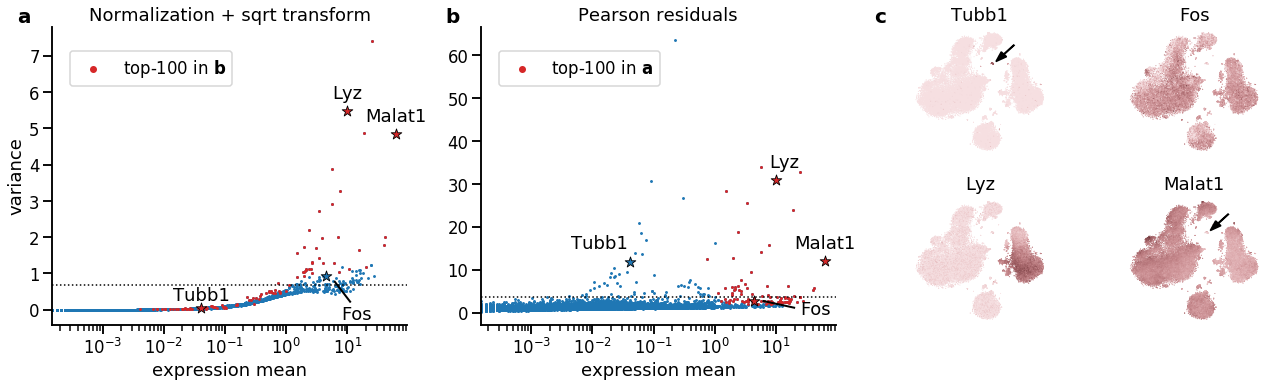

In [14]:
with sns.plotting_context("talk"):
    
    example_genes_idx = np.isin(dataset['genes'],example_genes)

    fig = plt.figure(figsize=(18,6))
    gs = GridSpec(2, 6, figure=fig) 
    
    ax1 = fig.add_subplot(gs[:, 0:2])
    ax2 = fig.add_subplot(gs[:, 2:4])    
    supaxis = fig.add_subplot(gs[:, 4:6])      
    ax3 = fig.add_subplot(gs[0, 4])  
    ax4 = fig.add_subplot(gs[1, 4])  
    ax5 = fig.add_subplot(gs[0, 5])  
    ax6 = fig.add_subplot(gs[1, 5])  
    
    tsne_axes = [ax3,ax4,ax5,ax6]
    tsne_arrows = [(28,39),None,None,(28,39)]
    
    ax1.text(*titleletter_loc,'a',transform=ax1.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax1.set_title('Normalization + sqrt transform')
    ax1.set_xscale('log')
    ax1.set_xlim((xmin,xmax))
    ax1.set_xlabel(xmean_label)
    ax1.set_ylabel('variance')
    ax1.scatter(gene_means,sqrt_lazy_var,s=dotsize)
    ax1.scatter(gene_means[residuals_variable_genes_idx],sqrt_lazy_var[residuals_variable_genes_idx],color='tab:red',s=dotsize,label=r'top-100 in $\bf{b}$')
    ax1.scatter(gene_means[residuals_variable_genes_idx & example_genes_idx],sqrt_lazy_var[residuals_variable_genes_idx & example_genes_idx],color='tab:red',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax1.scatter(gene_means[~residuals_variable_genes_idx & example_genes_idx],sqrt_lazy_var[~residuals_variable_genes_idx & example_genes_idx],color='tab:blue',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax1.hlines(sqrt_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)
    
    add_labels(dataset,xdata=gene_means, ydata=sqrt_lazy_var,example_genes=example_genes,textoffsets=example_gene_textoffsets_a,lines=example_gene_lines_a,ax=ax1)
    add_largedot_legend(ax1,legend_loc)
  
    ax2.text(*titleletter_loc,'b',transform=ax2.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax2.set_title('Pearson residuals')
    ax2.set_xscale('log')
    ax2.set_xlim((xmin,xmax))
    ax2.set_xlabel(xmean_label)    
    ax2.scatter(gene_means,residual_var,s=dotsize)
    ax2.scatter(gene_means[sqrt_variable_genes_idx],residual_var[sqrt_variable_genes_idx],color='tab:red',s=dotsize,label=r'top-100 in $\bf{a}$')    
    ax2.scatter(gene_means[example_genes_idx & sqrt_variable_genes_idx],residual_var[example_genes_idx & sqrt_variable_genes_idx],color='tab:red',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax2.scatter(gene_means[example_genes_idx & ~sqrt_variable_genes_idx],residual_var[example_genes_idx & ~sqrt_variable_genes_idx],color='tab:blue',s=starsize,marker='*',edgecolors='k',linewidths=staredges)
    ax2.hlines(residuals_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)    

    add_labels(dataset,xdata=gene_means, ydata=residual_var,example_genes=example_genes,textoffsets=example_gene_textoffsets_b,lines=example_gene_lines_b,ax=ax2)
    add_largedot_legend(ax2,legend_loc)    
        
    supaxis.text(*titleletter_loc,'c',transform=supaxis.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)    
    supaxis.axis('off')
    for (tsne_ax,tsne_arrow,example_gene) in zip(tsne_axes,tsne_arrows,example_genes):        
    
        gene_idx = dataset['genes'] == example_gene
        sqrt_lazy_counts = np.squeeze(dataset['sqrt_lazy'][:,gene_idx])
        tsne_ax.set_title(example_gene.lower().capitalize())
        tsne_ax.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1,c=sqrt_lazy_counts, edgecolor='none',cmap=cmap)
        if tsne_arrow:
            tsne_ax.arrow(*tsne_arrow,-8,-8,width=0.5,head_width=6,shape='full',facecolor='k')
        tsne_ax.axis('off')
        
    sns.despine()
    plt.tight_layout()

## Figure S3

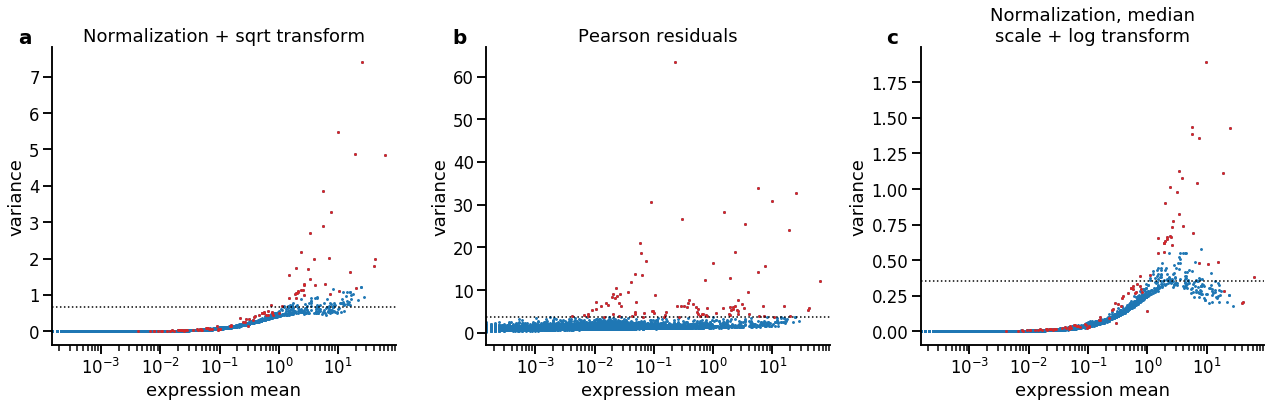

In [15]:
with sns.plotting_context("talk"):
    
    example_genes_idx = np.isin(dataset['genes'],example_genes)

    fig = plt.figure(figsize=(18,6))
    gs = GridSpec(2, 6, figure=fig) 
    
    ax1 = fig.add_subplot(gs[:, 0:2])
    ax2 = fig.add_subplot(gs[:, 2:4])    
    ax3 = fig.add_subplot(gs[:, 4:6])      
    
    ax1.text(*titleletter_loc,'a',transform=ax1.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax1.set_title('Normalization + sqrt transform')
    ax1.set_xscale('log')
    ax1.set_xlim((xmin,xmax))
    ax1.set_xlabel(xmean_label)
    ax1.set_ylabel('variance')
    ax1.scatter(gene_means,sqrt_lazy_var,s=dotsize)
    ax1.scatter(gene_means[residuals_variable_genes_idx],sqrt_lazy_var[residuals_variable_genes_idx],color='tab:red',s=dotsize,label=r'top-100 in Pearson residuals')
    ax1.hlines(sqrt_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)    
        
    ax2.text(*titleletter_loc,'b',transform=ax2.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax2.set_title('Pearson residuals')
    ax2.set_xscale('log')
    ax2.set_xlim((xmin,xmax))
    ax2.set_xlabel(xmean_label)
    ax2.set_ylabel('variance')
    ax2.scatter(gene_means,residual_var,s=dotsize)
    ax2.scatter(gene_means[residuals_variable_genes_idx],residual_var[residuals_variable_genes_idx],color='tab:red',s=dotsize)
    ax2.hlines(residuals_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)    
    
    
    ax3.text(*titleletter_loc,'c',transform=ax3.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax3.set_title('Normalization, median\nscale + log transform')
    ax3.set_xscale('log')
    ax3.set_xlim((xmin,xmax))
    ax3.set_xlabel(xmean_label)
    ax3.set_ylabel('variance')
    ax3.scatter(gene_means,log1p_medianscale_var,s=dotsize)
    ax3.scatter(gene_means[residuals_variable_genes_idx],log1p_medianscale_var[residuals_variable_genes_idx],color='tab:red',s=dotsize)
    ax3.hlines(log1p_medianscale_threshold,xmin,xmax,linestyle=':',linewidth=hline_width)    
    
    sns.despine()
    plt.tight_layout()

#### Additional comparison to the Hafemeister & Satija (2019) gene selection

In [16]:
### Genes selected by H&S (see Hafemeister & Satija, Figure 4C)
variable_genes_orig = ['TUBB1','CLU','PTGDS','GNG11','SDPR','PF4','PPBP','HIST1H2AC','MZB1','IGJ','IGLL5','GZMB','GNLY','S100A8','NKG7','S100A9','CCL5','LYZ','FTL','FTH1']
variable_genes_orig_idx = np.isin(dataset['genes'],variable_genes_orig)


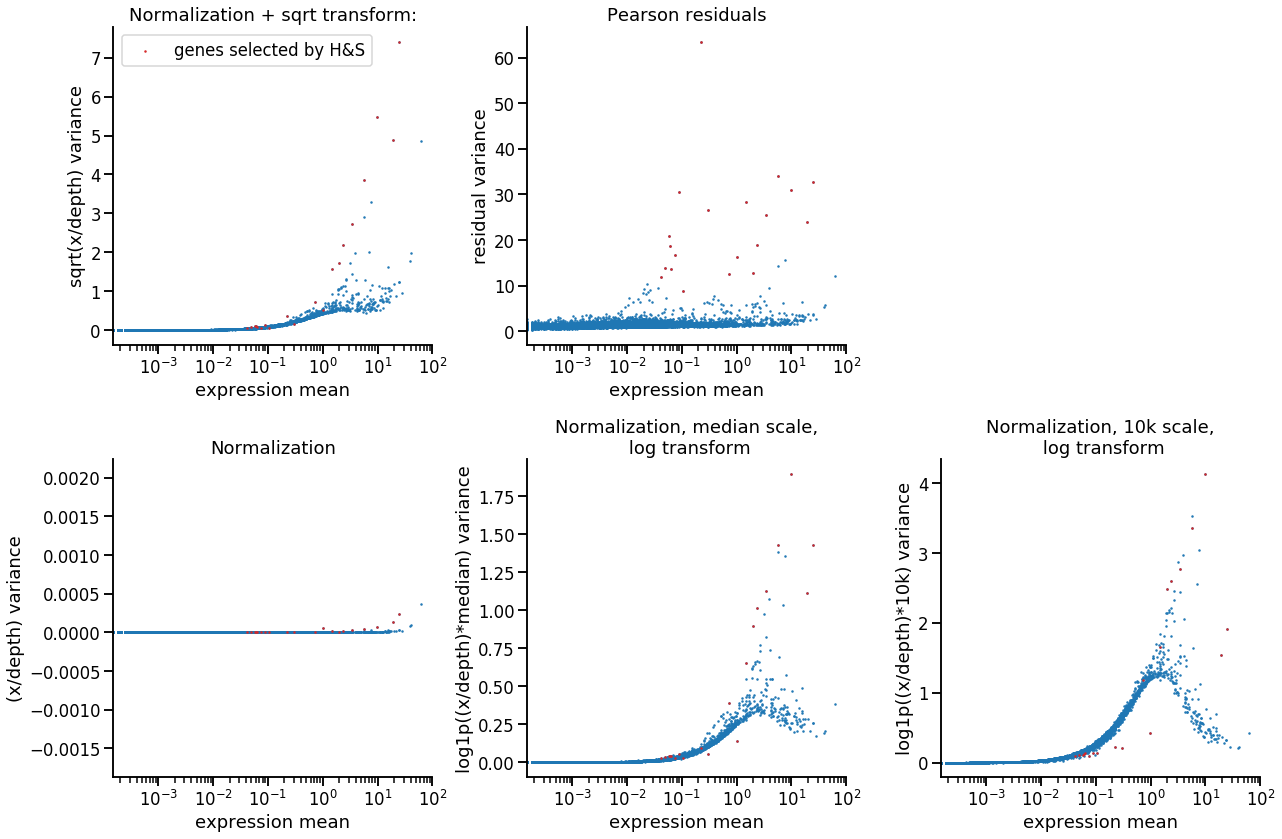

In [17]:
##compare Pearson Residuals and sqrt() to H&S selection
with sns.plotting_context('talk'):
    
    plt.figure(figsize=(18,12))
    
    plt.subplot(231)
    plt.scatter(gene_means,sqrt_lazy_var,s=1)
    plt.scatter(gene_means[variable_genes_orig_idx],sqrt_lazy_var[variable_genes_orig_idx],color='tab:red',s=1,label='genes selected by H&S')
    plt.legend()
    plt.title('Normalization + sqrt transform:')
    plt.xscale('log')
    plt.xlim((min(gene_means),100))
    plt.xlabel(xmean_label)
    plt.ylabel('sqrt(x/depth) variance')
    
    plt.subplot(232)    
    plt.scatter(gene_means,residual_var,s=1)
    plt.scatter(gene_means[variable_genes_orig_idx],residual_var[variable_genes_orig_idx],color='tab:red',s=5,marker='.',label='genes selected by H&S')
    plt.title('Pearson residuals')
    plt.xscale('log')
    plt.xlim((min(gene_means),100))
    plt.xlabel(xmean_label)
    plt.ylabel('residual variance')

    
    plt.subplot(234)
    plt.scatter(gene_means,normalized_var,s=1)
    plt.scatter(gene_means[variable_genes_orig_idx],normalized_var[variable_genes_orig_idx],color='tab:red',s=1,label='genes selected by H&S')
    plt.title('Normalization')
    plt.xscale('log')
    plt.xlim((min(gene_means),100))
    plt.xlabel(xmean_label)
    plt.ylabel('(x/depth) variance')
    
    plt.subplot(235)    
    plt.scatter(gene_means,log1p_medianscale_var,s=1)
    plt.scatter(gene_means[variable_genes_orig_idx],log1p_medianscale_var[variable_genes_orig_idx],color='tab:red',s=1)
    plt.title('Normalization, median scale,\n log transform')
    plt.xscale('log')
    plt.xlim((min(gene_means),100))
    plt.xlabel(xmean_label)
    plt.ylabel('log1p((x/depth)*median) variance')

    plt.subplot(236)    
    plt.scatter(gene_means,log1p_10kscale_var,s=1)
    plt.scatter(gene_means[variable_genes_orig_idx],log1p_10kscale_var[variable_genes_orig_idx],color='tab:red',s=1)
    plt.title('Normalization, 10k scale,\n log transform')
    plt.xscale('log')
    plt.xlim((min(gene_means),100))
    plt.xlabel(xmean_label)
    plt.ylabel('log1p((x/depth)*10k) variance')
    sns.despine()
    plt.tight_layout()

# Dimensionality reduction

#### Prepare clustering annotations

In [18]:
#load k means clustering from 10X
k = 10
clusters = np.array(pd.read_csv('datasets/33k_pbmc/analysis/kmeans/10_clusters/clusters.csv')['Cluster'])

#define a mapping from cluster ID to genes (explained in additional plots below)
mapping_clusters2genes = {1:'CD3D+CCR7',       2:'S100A8',    3:'CD3D+GZMK',           4: 'CD3D',                5:'MS4A1',                    6: 'PF4',       7: 'unmarked', 8:'GNLY',       9:'unmarked',       10:'IRF7'}   
#define a mapping cluster ID to our cell type annotations  (explained in additional plots below)
mapping_clusters2typenames = {1:'Naive T cells',   2:'Monocytes', 3:'CD8+mem. T cells', 4: 'CD4+mem. T cells', 5:'Naive+mem. B cells',  6: 'Platelets', 7: 'unmarked', 8:'NK cells',   9:'unmarked', 10:'pDCs'}
marker_offset = {1:[-10,-25],         2:[0,-20],     3: [-20,+8],              4: [3,-30],               5: [+23,-3],                   6: [-5,5],      7: [0,0],      8: [15,0],      9: [0,0],    10: [-2,2]}   


cluster_ids = np.unique(clusters)
cluster_names = [mapping_clusters2typenames[i] for i in cluster_ids]
cluster_genes = [mapping_clusters2genes[i] for i in cluster_ids]

## Figure S1
#### Depth-colored tSNE embeddings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


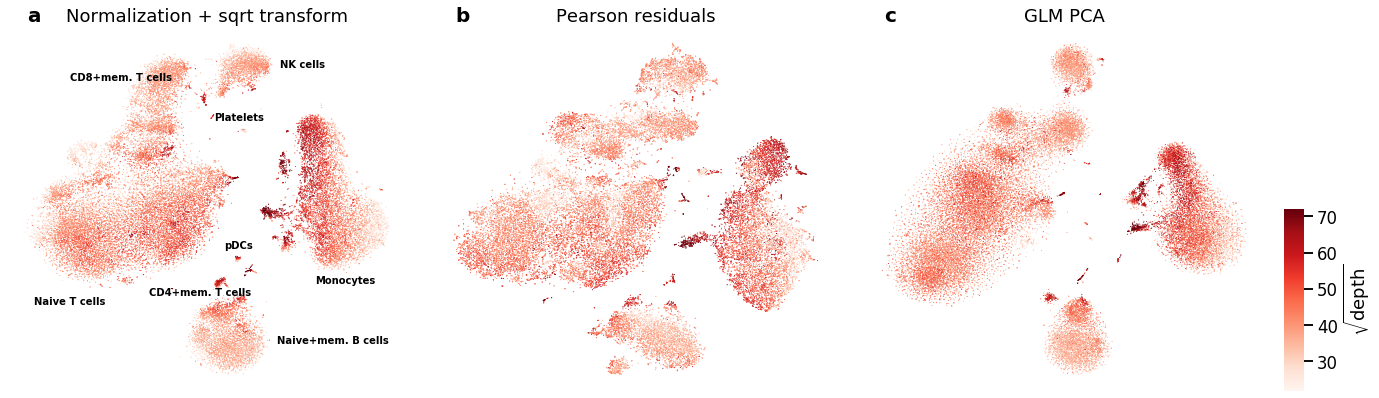

In [19]:
depths = np.squeeze(np.array(np.sum(counts,axis=1)))
sqrtdepths = np.sqrt(depths)

tsnes =  [ sqrt_lazy_tsne,                 residuals_theta100_tsne,  glmpcaPy_nb_thetaFixed_tsne]
titles = ['Normalization + sqrt transform', 'Pearson residuals',      'GLM PCA']
letters = ['a','b','c']

with sns.plotting_context('talk'):
    plt.figure(figsize=(18,6))
    
    for i, (tsne,title,letter) in enumerate(zip(tsnes,titles,letters)):
        
        plt.subplot(131+i)
        ax=plt.gca()
        plt.text(0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

        plt.scatter(tsne['coords'][:,0], tsne['coords'][:,1], s=1, edgecolor='none',c=np.sqrt(depths),cmap='Reds',vmax=72)
        if i==2:
            #make colorbar
            ax=plt.gca()
            axins1 = inset_axes(ax,
                                 width="5%",  
                                 height="50%", 
                                 loc=('lower left'),
                                 bbox_to_anchor=(1.05, 0., 1, 1),
                                 bbox_transform=ax.transAxes,
                                 borderpad=0)

            cb = plt.colorbar(cax=axins1, orientation="vertical",ticks=[20,30,40,50,60,70])
            axins1.set_ylabel(r'$\sqrt{\mathrm{depth}}$')
            cb.outline.set_visible(False)

        if i == 0:
            
            for cluster_id in np.unique(clusters):
                cluster_idx = clusters == cluster_id
                if not cluster_id in [9,7]:
                    #compute center of current cluster
                    this_cluster_mean = np.mean(tsne['coords'][cluster_idx,:],axis=0) + marker_offset[cluster_id]
                    #place text
                    plt.text(this_cluster_mean[0]-len(mapping_clusters2typenames[cluster_id])/2,this_cluster_mean[1],mapping_clusters2typenames[cluster_id],fontsize=10,fontweight='bold')


        plt.tight_layout()
        sns.despine(left=True,bottom=True)

## Figure S4
#### Cluster-colored tSNEs, based on full dataset vs. dataset after gene selection with analytical Pearson residuals

In [20]:
## Load gene selection tSNEs
with open('tsne/tsne_pbmc_maxResSelection_sqrt_lazy_initsqrtLazy.pickle','rb') as f:
    maxResSelection_sqrt_lazy_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_maxResSelection_residuals_theta100_initsqrtLazy.pickle','rb') as f:
    maxResSelection_residuals_theta100_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_maxResSelection_glmpca_nb_thetaFixed100_initsqrtLazy.pickle','rb') as f:
    maxResSelection_glmpca_nb_thetaFixed100_tsne = pickle.load(f)

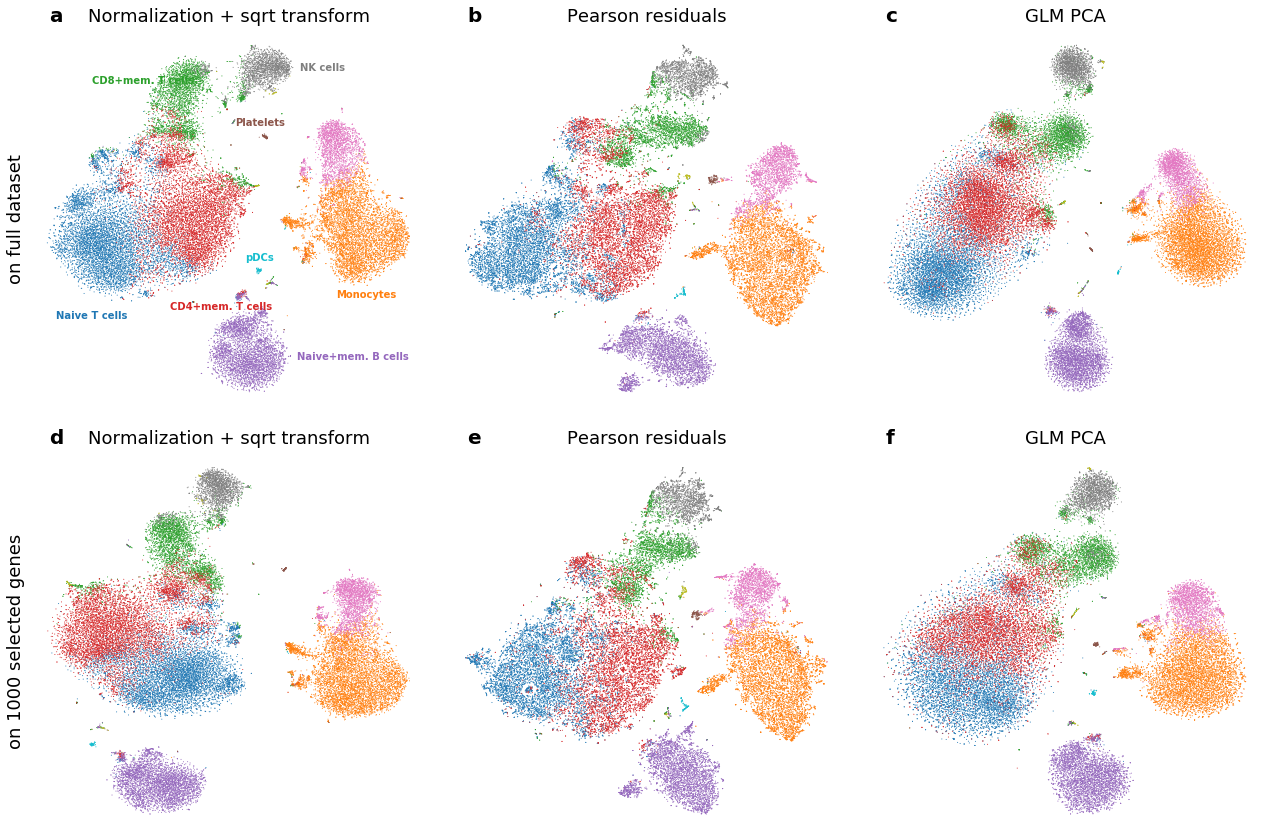

In [21]:
tsnes =  [ sqrt_lazy_tsne,                 residuals_theta100_tsne,                   glmpcaPy_nb_thetaFixed_tsne,
         maxResSelection_sqrt_lazy_tsne,   maxResSelection_residuals_theta100_tsne,   maxResSelection_glmpca_nb_thetaFixed100_tsne]
titles = ['Normalization + sqrt transform', 'Pearson residuals',      'GLM PCA',
          'Normalization + sqrt transform', 'Pearson residuals',      'GLM PCA',]
ylabels = ['on full dataset','','',
           'on 1000 selected genes','','']
letters = ['a','b','c','d','e','f']

with sns.plotting_context('talk'):
    plt.figure(figsize=(18,12))
    
    for i, (tsne,title,letter,ylabel) in enumerate(zip(tsnes,titles,letters,ylabels)):
        
        plt.subplot(231+i)
        ax=plt.gca()
        plt.text(0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        ax.set_ylabel(ylabel)
    
        for cluster_id in np.unique(clusters):
            cluster_idx = clusters == cluster_id
            

            points=plt.scatter(tsne['coords'][cluster_idx,0], tsne['coords'][cluster_idx,1], s=1, edgecolor='none')
            if i == 0:
                color = points.get_facecolor().flatten()
                if not cluster_id in [9,7]:
                    #compute center of current cluster
                    this_cluster_mean = np.mean(tsne['coords'][cluster_idx,:],axis=0) + marker_offset[cluster_id]
                    #place text
                    plt.text(this_cluster_mean[0]-len(mapping_clusters2typenames[cluster_id])/2,this_cluster_mean[1],mapping_clusters2typenames[cluster_id],fontsize=10,fontweight='bold',color=color)


            plt.tight_layout()
            sns.despine(left=True,bottom=True)

#### Additional plot showing tSNE based on normalization only or log transform

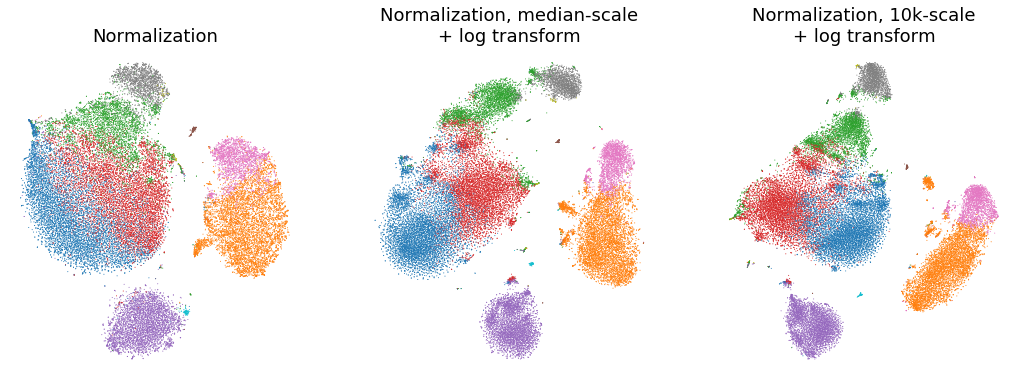

In [22]:
tsnes =  [normalized_tsne,                   log1p_medianscale_tsne,          log1p_10kscale_tsne]
titles = ['Normalization', 'Normalization, median-scale\n+ log transform', 'Normalization, 10k-scale\n+ log transform']

with sns.plotting_context('talk'):
    f =plt.figure(figsize=(18,6))
    
    for i,(tsne,title) in enumerate(zip(tsnes,titles)):
        plt.subplot(131+i)
        plt.title(title)
        points = plt.scatter(tsne['coords'][:,0],tsne['coords'][:,1], s=1, edgecolor='none',c=clusters,cmap='tab10')
        plt.axis('off')

### Justify the above mapping from 10X clusters to marker genes and cell types

#### Additional tSNE showing our mapping from 10X cluster to marker gene / PBMC cell type

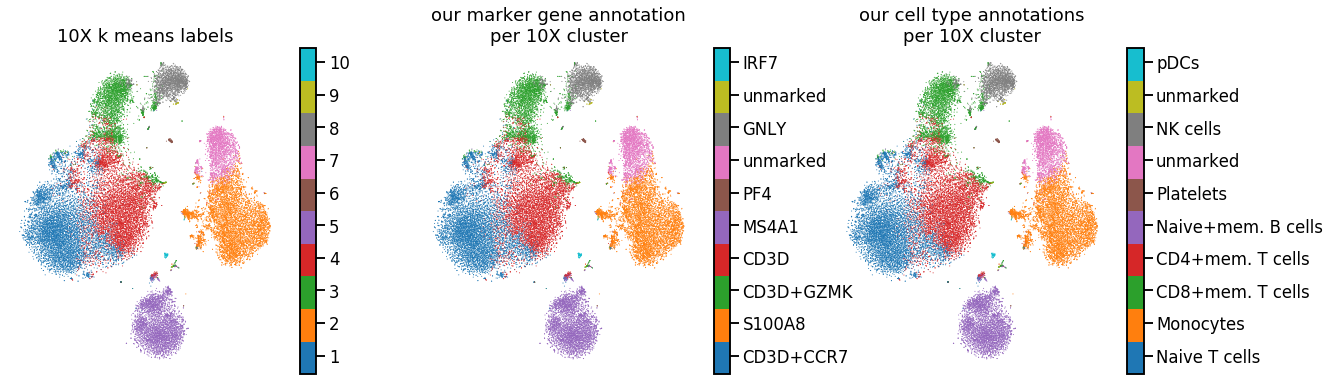

In [23]:
tsnes =  [sqrt_lazy_tsne,sqrt_lazy_tsne,sqrt_lazy_tsne]
titles = ['10X k means labels','our marker gene annotation\nper 10X cluster','our cell type annotations\nper 10X cluster']
cluster_names_thisplot = [[str(i) for i in range(1,11,1)],cluster_genes,cluster_names]

with sns.plotting_context('talk'):
    f =plt.figure(figsize=(21,6))
    
    for i,(tsne,title) in enumerate(zip(tsnes,titles)):
        plt.subplot(131+i)
        plt.title(title)
        points = plt.scatter(tsne['coords'][:,0],tsne['coords'][:,1], s=1, edgecolor='none',c=clusters,cmap='tab10')
        plt.axis('off')
    
        cbar = plt.colorbar(ticks=np.linspace(1.5,10.5,11))
        cbar.ax.set_yticklabels(cluster_names_thisplot[i])


#### Additional tSNEs showing the expression of 10 PBMC cell type marker genes (Wagner, 2020)

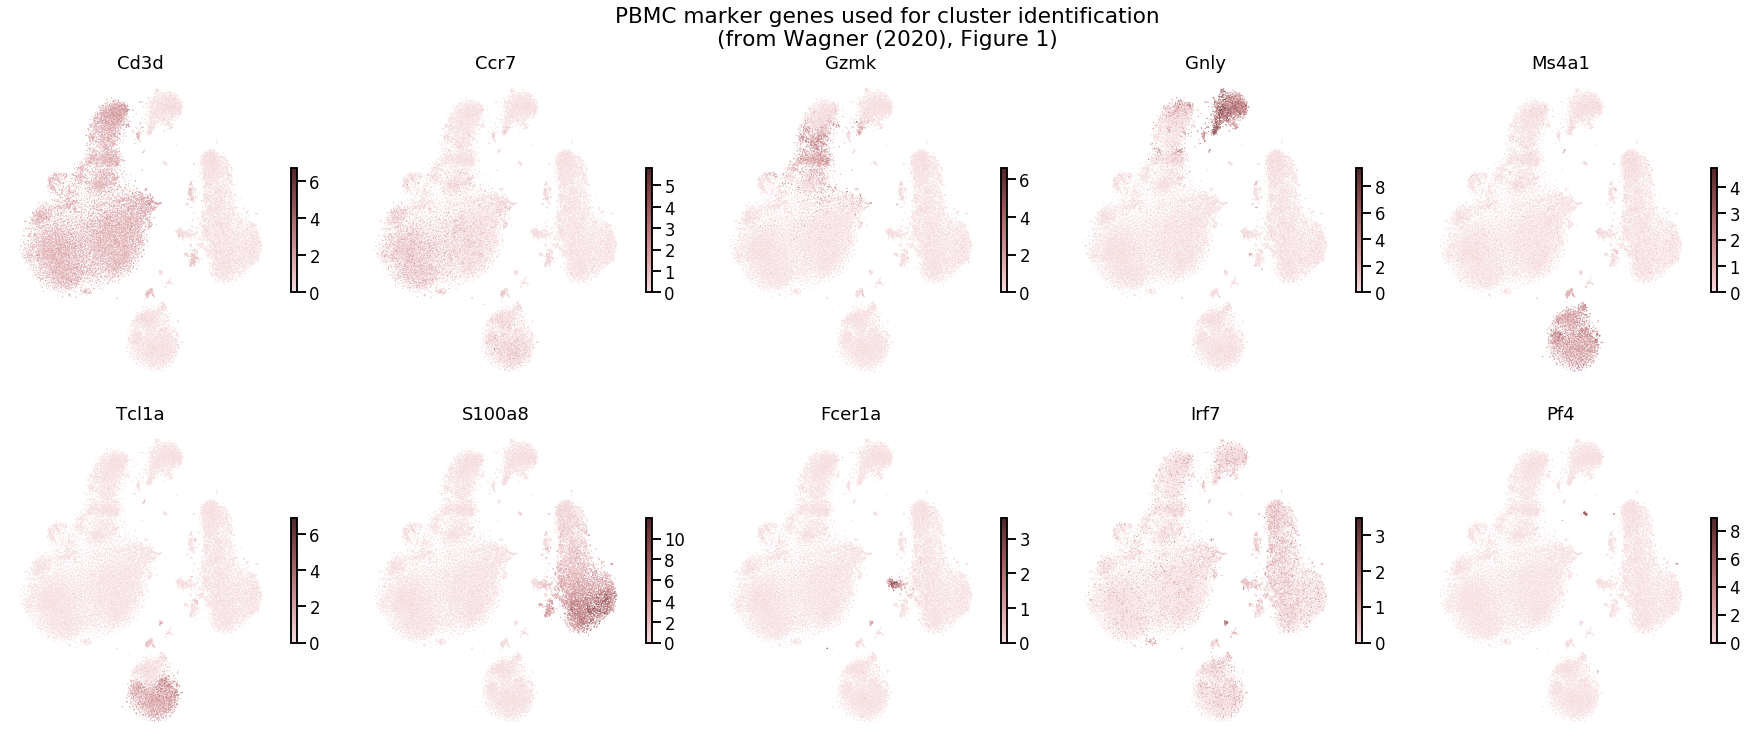

In [24]:
#from Figure 1 of https://www.biorxiv.org/content/10.1101/770388v3.full
marker_genes=['CD3D', 'CCR7', 'GZMK', 'GNLY', 'MS4A1', 'TCL1A', 'S100A8', 'FCER1A', 'IRF7', 'PF4']

with sns.plotting_context('talk'):
    
    fig,axes = plt.subplots(2,5,figsize=(25,10))


    for i,(marker_gene,ax) in enumerate(zip(marker_genes,axes.flatten())):

        gene_idx = dataset['genes'] == marker_gene
        sqrt_counts = np.squeeze(dataset['sqrt_lazy'][:,gene_idx])

        ax.set_title(marker_gene.capitalize())
        sc=ax.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1,c=sqrt_counts, edgecolor='none',cmap=cmap)
        plt.colorbar(sc,ax=ax,shrink=0.4)
        ax.axis('off')
    plt.suptitle('PBMC marker genes used for cluster identification\n(from Wagner (2020), Figure 1)',y=1.04)
    plt.tight_layout()
    sns.despine()

# Downsampling experiment

#### Load metadata of the  downsampled dataset

In [25]:
with open('pbmc_downsampling_experiment_data.pickle','rb') as f:
    downsampling_data = pickle.load(f)

#### Load tSNEs of downsampling experiment

In [26]:
with open('tsne/tsne_pbmc_downsamplingExp_log1p_normalized_scale10k.pickle','rb') as f:    
    log1p10k_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_log1p_normalized_scaleMedian.pickle','rb') as f:    
    log1pMedian_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_normalized.pickle','rb') as f:
    normalized_downsampling_tsne = pickle.load(f)    
with open('tsne/tsne_pbmc_downsamplingExp_sqrt_normalized.pickle','rb') as f:    
    sqrt_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_residuals.pickle','rb') as f:
    residuals_downsampling_tsne = pickle.load(f)
with open('tsne/tsne_pbmc_downsamplingExp_glmpca.pickle','rb') as f:
    glmpca_downsampling_tsne = pickle.load(f)

## Figure S6

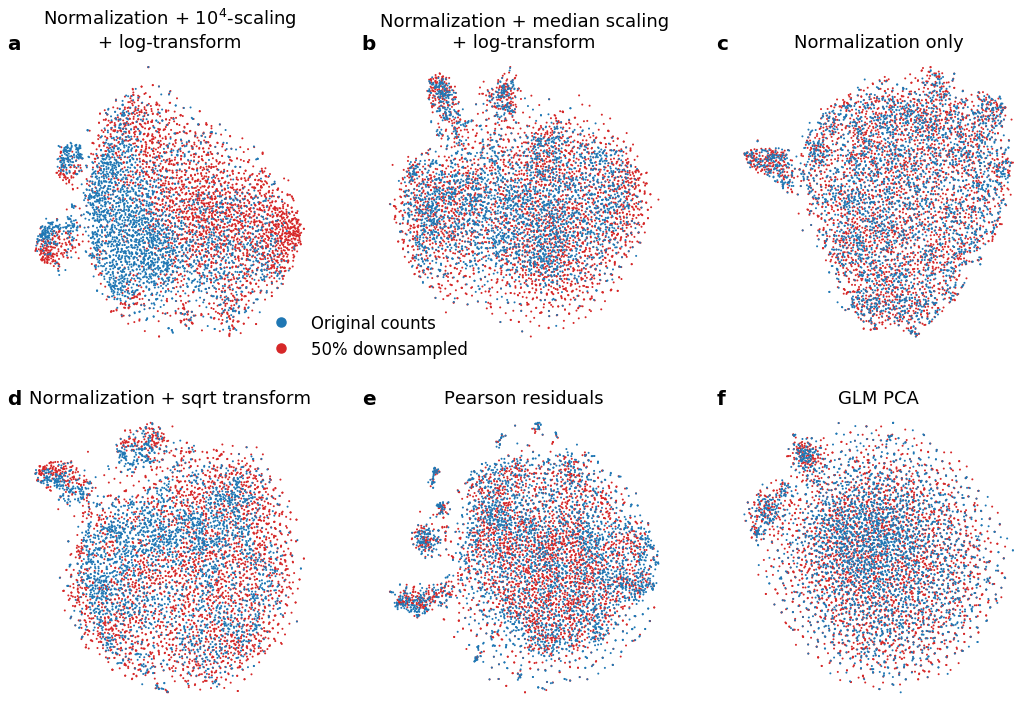

In [27]:
from matplotlib.colors import ListedColormap

cmap_downsampling = ListedColormap(['tab:blue','tab:red'])

downsampled_idx = downsampling_data['downsampled_idx']
downsampling_labels =  downsampling_data['downsampling_labels']

with sns.plotting_context('talk'):
    fig,axes = plt.subplots(2,3,figsize=(18,12))
    tsnes = [log1p10k_downsampling_tsne,log1pMedian_downsampling_tsne, normalized_downsampling_tsne,
             sqrt_downsampling_tsne, residuals_downsampling_tsne, glmpca_downsampling_tsne]
    labels = [r'Normalization + $10^{4}$-scaling' '\n+ log-transform', 'Normalization + median scaling\n+ log-transform', 'Normalization only',
             'Normalization + sqrt transform', 'Pearson residuals', 'GLM PCA']
    letters = ['a','b','c','d','e','f']

    for i,(ax,tsne,label,letter) in enumerate(zip(axes.flatten(),tsnes,labels,letters)):

        plt.text(-0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        scatter = ax.scatter(tsne['coords'][:,0], tsne['coords'][:,1], s=4, edgecolor='none',c=downsampled_idx,cmap=cmap_downsampling)
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i==1:
            ax.legend(handles=scatter.legend_elements()[0],labels=downsampling_labels,frameon=False,loc=(-0.4,-0.05))
        
        
    sns.despine(left=True,bottom=True)

#### Additional plot: Figure S6 with depth coloring

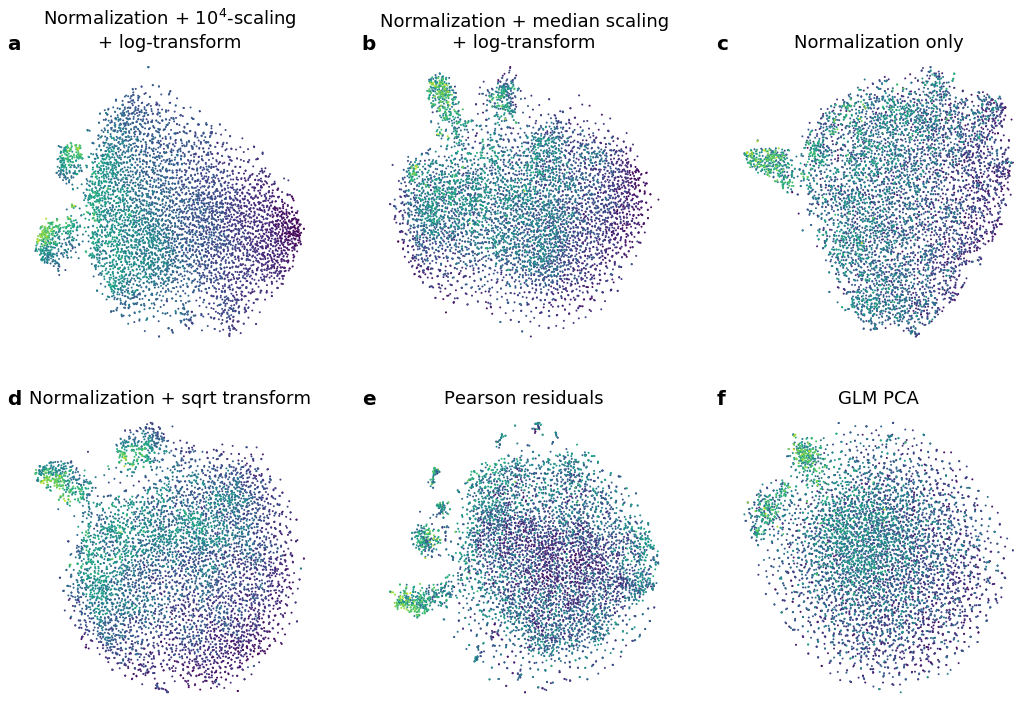

In [28]:
with sns.plotting_context('talk'):
    fig,axes = plt.subplots(2,3,figsize=(18,12))
    tsnes = [log1p10k_downsampling_tsne,log1pMedian_downsampling_tsne, normalized_downsampling_tsne,
             sqrt_downsampling_tsne, residuals_downsampling_tsne, glmpca_downsampling_tsne]
    labels = [r'Normalization + $10^{4}$-scaling' '\n+ log-transform', 'Normalization + median scaling\n+ log-transform', 'Normalization only',
             'Normalization + sqrt transform', 'Pearson residuals', 'GLM PCA']
    letters = ['a','b','c','d','e','f']

    for i,(ax,tsne,label,letter) in enumerate(zip(axes.flatten(),tsnes,labels,letters)):

        plt.text(-0.05,1.015,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        scatter = ax.scatter(tsne['coords'][:,0], tsne['coords'][:,1], s=4, edgecolor='none',c=np.sqrt(downsampling_data['depths']))
        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
    sns.despine(left=True,bottom=True)

#### Additional plot: tSNEs indentifying cluster #2 with CD14-positive monocytes

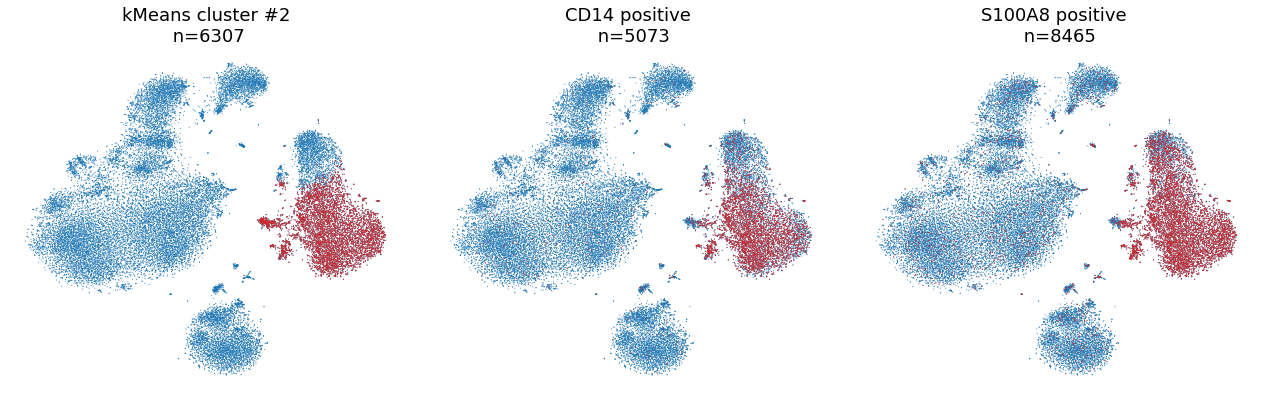

In [29]:
## compare kmeans cluster #2 with published monocyte markers
cd14_idx = (dataset['genes']=='CD14')
cd14 = np.squeeze(counts[:,cd14_idx])
cd14_positive_idx = cd14>0

monocytemarker_idx = (dataset['genes']=='S100A8')
monocytemarker_counts = np.squeeze(counts[:,monocytemarker_idx])
monocytemarker_positive_idx = monocytemarker_counts>0

#plot CD14 expression map and cluster 2 map
with sns.plotting_context('talk'):
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1, edgecolor='none')
    plt.scatter(sqrt_lazy_tsne['coords'][clusters==2,0], sqrt_lazy_tsne['coords'][clusters==2,1], c="tab:red",s=1, edgecolor='none')
    plt.title('kMeans cluster #2\n n=%u'%(sum(clusters==2)))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1, edgecolor='none')
    plt.scatter(sqrt_lazy_tsne['coords'][cd14_positive_idx,0], sqrt_lazy_tsne['coords'][cd14_positive_idx,1], c="tab:red",s=1, edgecolor='none')
    plt.title('CD14 positive \n n=%u'%(sum(cd14_positive_idx)))

    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.scatter(sqrt_lazy_tsne['coords'][:,0], sqrt_lazy_tsne['coords'][:,1], s=1, edgecolor='none')
    plt.scatter(sqrt_lazy_tsne['coords'][monocytemarker_positive_idx,0], sqrt_lazy_tsne['coords'][monocytemarker_positive_idx,1], c="tab:red",s=1, edgecolor='none')
    plt.title('S100A8 positive \n n=%u'%(sum(monocytemarker_positive_idx)))

    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    sns.despine(left=True,bottom=True)

## Figure S8:
#### Cluster-colored tSNE of GLM PCAs with different noise model settings

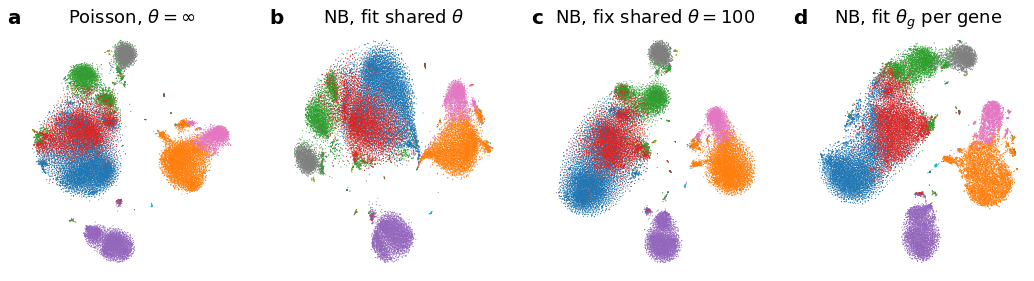

In [30]:
with sns.plotting_context('talk'):
    tsnes = [glmpca_poi_lowTol_tsne, glmpca_nb_tsne, glmpcaPy_nb_thetaFixed_tsne, glmpca_nb2_tsne]
    labels = [r'Poisson, $\theta=\infty$',
             r'NB, fit shared $\theta$',
             r'NB, fix shared $\theta=100$',
             r'NB, fit $\theta_g$ per gene']
    letters = ['a','b','c','d']
    fig,axes = plt.subplots(1,4,figsize=(18,4.5))
    for ax,tsne,label,letter in zip(axes.flatten(),tsnes,labels,letters):      
    
        ax.set_title(label)
        plt.text(-0.07,1.02,letter,transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
        ax.set_xticks([])
        ax.set_yticks([])
        if tsne is None:
            continue
        if letter=='d':
            ax.set_title(label,position=(0.5,0.995))

        ax.scatter(tsne['coords'][:,0], tsne['coords'][:,1],c=clusters,cmap='tab10', s=1, edgecolor='none')    

    sns.despine(left=True,bottom=True)

#### Additional plots: All tSNEs colored by depth

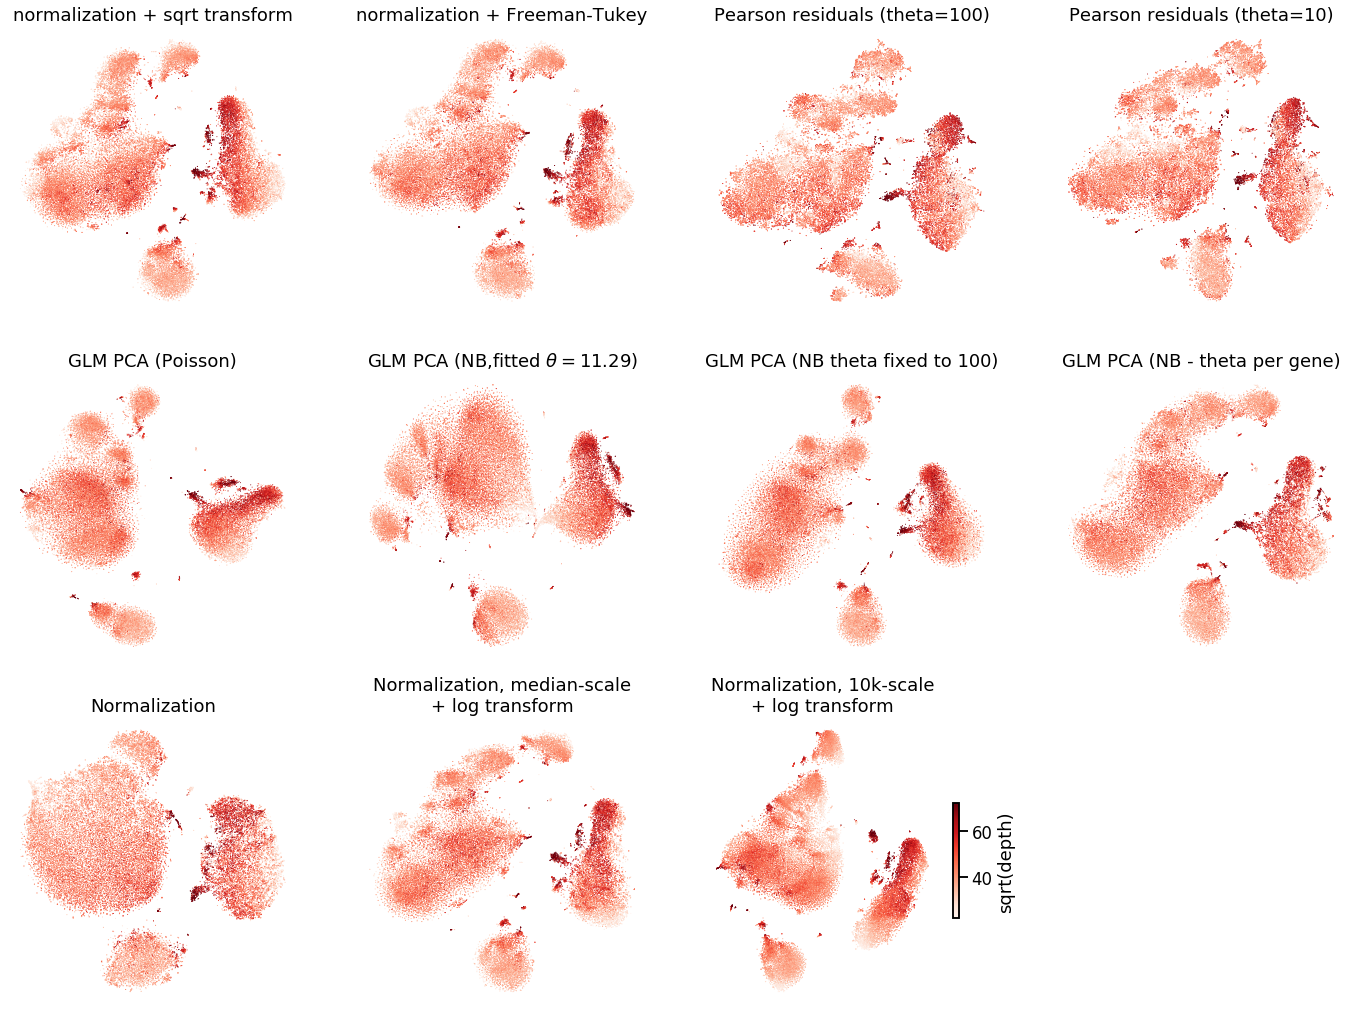

In [32]:
depths = np.squeeze(np.array(np.sum(counts,axis=1)))
sqrtdepths = np.sqrt(depths)

tsnes =  [sqrt_lazy_tsne,     sqrt_full_tsne,       residuals_theta100_tsne,          residuals_theta10_tsne,
          glmpca_poi_lowTol_tsne,    
          glmpca_nb_tsne,       
          glmpcaPy_nb_thetaFixed_tsne,      
          glmpca_nb2_tsne,
          normalized_tsne, log1p_medianscale_tsne, log1p_10kscale_tsne]
titles = ['normalization + sqrt transform',          'normalization + Freeman-Tukey',  'Pearson residuals (theta=100)',  'Pearson residuals (theta=10)',
          'GLM PCA (Poisson)',
          r'GLM PCA (NB,fitted $\theta=$' f'{glmpca_nb_theta:.2f})', 
          'GLM PCA (NB theta fixed to 100)',
          'GLM PCA (NB - theta per gene)',
          'Normalization', 'Normalization, median-scale\n+ log transform', 'Normalization, 10k-scale\n+ log transform']
with sns.plotting_context('talk'):
    f =plt.figure(figsize=(24,18))
    
    for i,(tsne,title) in enumerate(zip(tsnes,titles)):
        plt.subplot(3,4,1+i)
        plt.title(title)
        points = plt.scatter(tsne['coords'][:,0],tsne['coords'][:,1], s=1, edgecolor='none',c=sqrtdepths,cmap='Reds',vmax=72)
        plt.axis('off')
    cbar = f.colorbar(points, panchor=(1,0),shrink=0.4)
    cbar.set_label('sqrt(depth)')